In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Setup


In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -q tensorflow-text

In [ ]:
!pip install -q tf-models-official

In [ ]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optmizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [ ]:
"""
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)
"""

"\nurl = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'\n\ndataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,\n                                  untar=True, cache_dir='.',\n                                  cache_subdir='')\n\ndataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')\n\ntrain_dir = os.path.join(dataset_dir, 'train')\n\n# remove unused folders to make it easier to load the data\nremove_dir = os.path.join(train_dir, 'unsup')\nshutil.rmtree(remove_dir)\n"

In [ ]:
"""
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
"""

"\nAUTOTUNE = tf.data.AUTOTUNE\nbatch_size = 32\nseed = 42\n\nraw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(\n    'aclImdb/train',\n    batch_size=batch_size,\n    validation_split=0.2,\n    subset='training',\n    seed=seed)\n\nclass_names = raw_train_ds.class_names\ntrain_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)\n\nval_ds = tf.keras.preprocessing.text_dataset_from_directory(\n    'aclImdb/train',\n    batch_size=batch_size,\n    validation_split=0.2,\n    subset='validation',\n    seed=seed)\n\nval_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)\n\ntest_ds = tf.keras.preprocessing.text_dataset_from_directory(\n    'aclImdb/test',\n    batch_size=batch_size)\n\ntest_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)\n"

Let's take a look at a few reviews.

In [ ]:
"""
for text_batch, label_batch in train_ds.take(1):
  print (text_batch)
  print (label_batch)
  #for i in range(3):
    #print(f'Review: {text_batch.numpy()[i]}')
    #label = label_batch.numpy()[i]
    #print(f'Label : {label} ({class_names[label]})')
"""

"\nfor text_batch, label_batch in train_ds.take(1):\n  print (text_batch)\n  print (label_batch)\n  #for i in range(3):\n    #print(f'Review: {text_batch.numpy()[i]}')\n    #label = label_batch.numpy()[i]\n    #print(f'Label : {label} ({class_names[label]})')\n"

In [ ]:
import pandas as pd
df_main = pd.read_csv('/content/drive/MyDrive/WSU/Winter_2021/CSC 7810/Final Project/df_main_res.csv')

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split  
train, test = sklearn.model_selection.train_test_split(df_main, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
train, val = sklearn.model_selection.train_test_split(train, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
train_f = pd.DataFrame(train['review'])
train_l = pd.DataFrame(train['target'])

val_f = pd.DataFrame(val['review'])
val_l = pd.DataFrame(val['target'])

test_f = pd.DataFrame(test['review'])
test_l = pd.DataFrame(test['target'])

In [ ]:
"""
train_f = train_f.tolist()
train_l = train_l.tolist()

val_f = val_f.tolist()
val_l = val_l.tolist()

test_f = test_f.tolist()
test_l = test_l.tolist()
"""

'\ntrain_f = train_f.tolist()\ntrain_l = train_l.tolist()\n\nval_f = val_f.tolist()\nval_l = val_l.tolist()\n\ntest_f = test_f.tolist()\ntest_l = test_l.tolist()\n'

In [ ]:
"""
seed = 42
BUFFER_SIZE = 128
BATCH_SIZE = 32

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices(([features], [labels]))#.cache()
  return ds
train_data = make_ds(train_f, train_l)
val_data = make_ds(val_f, val_l)
test_data = make_ds(test_f, test_l)
"""

'\nseed = 42\nBUFFER_SIZE = 128\nBATCH_SIZE = 32\n\ndef make_ds(features, labels):\n  ds = tf.data.Dataset.from_tensor_slices(([features], [labels]))#.cache()\n  return ds\ntrain_data = make_ds(train_f, train_l)\nval_data = make_ds(val_f, val_l)\ntest_data = make_ds(test_f, test_l)\n'

In [ ]:
"""
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)
"""

'\nAUTOTUNE = tf.data.AUTOTUNE\nbatch_size = 32\nseed = 42\n\ntrain_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)\nval_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)\ntest_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)\n'

In [ ]:
"""
train_batches = train_data.shuffle(len(train_l)).batch(32)
val_batches = val_data.shuffle(len(val_l)).batch(32)
test_batches = test_data.shuffle(len(test_l)).batch(32)
"""

'\ntrain_batches = train_data.shuffle(len(train_l)).batch(32)\nval_batches = val_data.shuffle(len(val_l)).batch(32)\ntest_batches = test_data.shuffle(len(test_l)).batch(32)\n'

In [ ]:
#x = df_main

In [ ]:
train_features = train_f.copy()
train_labels = train.pop('target')

val_features = val_f.copy()
val_labels = val.pop('target')

test_features = test_f.copy()
test_labels = test.pop('target')

In [ ]:
import numpy as np
train_features_dict = {name: np.array(value) 
                         for name, value in train_features.items()}

val_features_dict = {name: np.array(value) 
                         for name, value in val_features.items()}

test_features_dict = {name: np.array(value) 
                         for name, value in test_features.items()}                                                  

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((train_features_dict, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_features_dict, val_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_features_dict, test_labels))


In [ ]:
train_ds

<TensorSliceDataset shapes: ({review: ()}, ()), types: ({review: tf.string}, tf.int64)>

In [ ]:
train_batches = train_ds.shuffle(len(train_labels)).batch(32)
val_batches = val_ds.shuffle(len(val_labels)).batch(32)
test_batches = test_ds.shuffle(len(test_labels)).batch(32)

In [ ]:
train_batches

<BatchDataset shapes: ({review: (None,)}, (None,)), types: ({review: tf.string}, tf.int64)>

In [ ]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'electra_base'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/google/electra_base/2
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Let's try the preprocessing model on some text and see the output:

In [ ]:
text_test = ['tThis product is amazing. I recommend it for everyone']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [  101 23746 24158  4031  2003  6429  1012  1045 16755  2009  2005  3071]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


## Using the BERT model

Before putting BERT into your own model, let's take a look at its outputs. You will load it from TF Hub and see the returned values.

In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/google/electra_base/2
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[ 0.01185247 -0.01576639  0.20731862  0.27316624  0.08095039  0.4746971
  0.31455612 -0.11168411  0.03614121  0.15264508  0.23864761  0.19031325]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[ 0.01185303 -0.01576769  0.21036793 ...  0.21784908 -0.4125955
   0.35589108]
 [ 0.533901   -0.04690749  0.01199353 ...  0.2857837   0.18199188
  -0.26538584]
 [-0.0856567   0.17165668  0.9536985  ... -0.00437566  0.16191779
   0.12317719]
 ...
 [-0.14829491 -0.04502356 -0.23387393 ... -0.2790469  -0.2364134
  -0.19985704]
 [ 0.4301811   0.01689807 -0.02563445 ...  0.22071567  0.06105209
  -0.24708296]
 [-0.16419193 -0.3951504   0.6110941  ...  0.00745332 -0.17022395
   0.64014244]]


In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='review')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

Let's check that the model runs with the output of the preprocessing model.

In [ ]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.46741796]], shape=(1, 1), dtype=float32)


The output is meaningless, of course, because the model has not been trained yet.

Let's take a look at the model's structure.

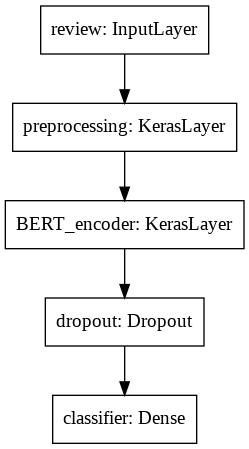

In [ ]:
tf.keras.utils.plot_model(classifier_model)

## Model training

You now have all the pieces to train a model, including the preprocessing module, BERT encoder, data, and classifier.

### Loss function

Since this is a binary classification problem and the model outputs a probability (a single-unit layer), you'll use `losses.BinaryCrossentropy` loss function.


In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

### Optimizer

For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as [AdamW](https://arxiv.org/abs/1711.05101).

For the learning rate (`init_lr`), we use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (`num_warmup_steps`). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [ ]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_batches).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

### Loading the BERT model and training

Using the `classifier_model` you created earlier, you can compile the model with the loss, metric and optimizer.

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_binary_accuracy', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=5, verbose=1)

Note: training time will vary depending on the complexity of the BERT model you have selected.

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_batches,
                               validation_data=val_batches,
                               epochs=epochs,
                               callbacks=[checkpoint, earlystopping])

Training model with https://tfhub.dev/google/electra_base/2
Epoch 1/10
2720/2720 [==============================] - 1557s 567ms/step - loss: 0.4902 - binary_accuracy: 0.7129 - val_loss: 0.2226 - val_binary_accuracy: 0.9129

Epoch 00001: val_binary_accuracy improved from -inf to 0.91294, saving model to model.h5
Epoch 2/10
2720/2720 [==============================] - 1543s 567ms/step - loss: 0.1980 - binary_accuracy: 0.9259 - val_loss: 0.1655 - val_binary_accuracy: 0.9468

Epoch 00002: val_binary_accuracy improved from 0.91294 to 0.94682, saving model to model.h5
Epoch 3/10
2720/2720 [==============================] - 1542s 567ms/step - loss: 0.1057 - binary_accuracy: 0.9662 - val_loss: 0.1469 - val_binary_accuracy: 0.9573

Epoch 00003: val_binary_accuracy improved from 0.94682 to 0.95725, saving model to model.h5
Epoch 4/10
2720/2720 [==============================] - 1540s 566ms/step - loss: 0.0706 - binary_accuracy: 0.9802 - val_loss: 0.1803 - val_binary_accuracy: 0.9630

Epoch 00004

### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents the error, lower values are better), and accuracy.

In [ ]:
loss, accuracy = classifier_model.evaluate(test_batches)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

850/850 [==============================] - 162s 191ms/step - loss: 0.2765 - binary_accuracy: 0.9652
Loss: 0.27654898166656494
Accuracy: 0.9651774168014526


### Plot the accuracy and loss over time

Based on the `History` object returned by `model.fit()`. You can plot the training and validation loss for comparison, as well as the training and validation accuracy:

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


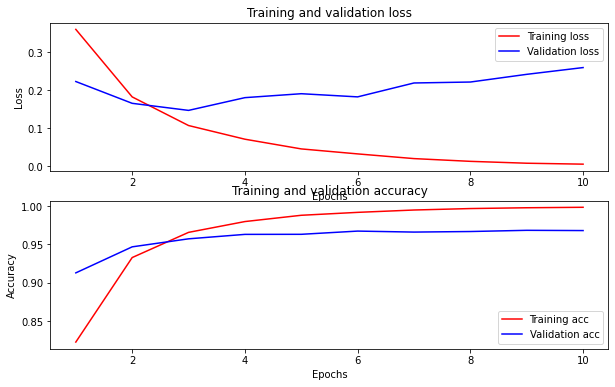

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In this plot, the red lines represents the training loss and accuracy, and the blue lines are the validation loss and accuracy.

## Save and Export model
I saved the model and its weights to classify new reviews.


In [ ]:
dataset_name = 'drug_reviews'
saved_model_path = '/content/drive/MyDrive/WSU/Winter 2021/CSC 7810/{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

Reload model to classify new data:

In [ ]:
import tensorflow as tf

reloaded_model = tf.saved_model.load(saved_model_path)

Get user's input (new drug review) to assign it a weight:

In [ ]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    input("Enter a review:")
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Enter a review:I do not recommend this product.
Results from the saved model:
input: I do not recommend this product. : score: 0.000031

Results from the model in memory:
input: I do not recommend this product. : score: 0.000031



In [ ]:
serving_results = reloaded_model \
            .signatures['serving_default'](tf.constant(examples))

serving_results = tf.sigmoid(serving_results['classifier'])

print_my_examples(examples, serving_results)

input: I do not recommend this product. : score: 0.000031

